<a href="https://colab.research.google.com/github/dsmlraghu/Calculator_1/blob/main/Cover_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Calculated Deflection: 0.3278 mm


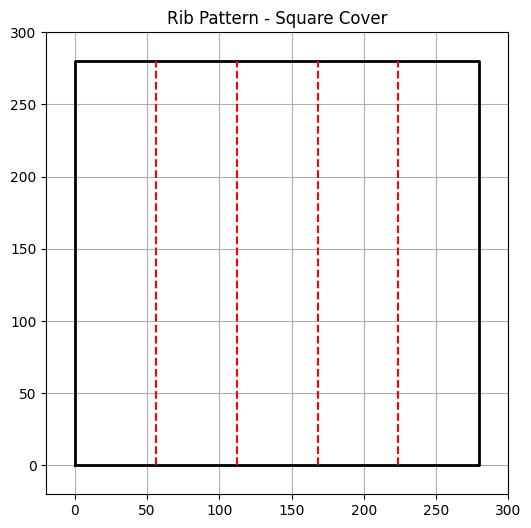

In [2]:
# -*- coding: utf-8 -*-
"""Cover_design_calculator.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1YMfomHE9z2-FgpnnZTZT8HoIULcGmi7a
"""

#pip install ipywidgets matplotlib

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load class values (N)
load_classes = {
    "A15": 15000,
    "B125": 125000,
    "C250": 250000,
    "D400": 400000,
    "E600": 600000,
    "F900": 900000
}

# Deflection calculation function
def calc_deflection(P, width, length, support, t_mm, E_GPa, nu,
                    rib_height_mm, rib_thickness_mm, num_ribs,
                    support_type, support_orientation, cover_type):

    E = E_GPa * 1e9
    t = t_mm / 1000

    if cover_type == "circular":
        r = (width - 2 * support) / 2 / 1000
        D = E * t**3 / (12 * (1 - nu**2))
        I_plate = (np.pi * r * t**3) / 4
        I_rib = (rib_thickness_mm / 1000) * (rib_height_mm / 1000)**3 / 12
        D_eff = D * (1 + num_ribs * I_rib / I_plate)
        delta = (3 * P * r**2) / (4 * np.pi * D_eff)
        return delta * 1000

    else:
        a = (width - 2 * support) / 1000
        b = (length - 2 * support) / 1000
        if a > b:
            a, b = b, a
        D = E * t**3 / (12 * (1 - nu**2))
        I_plate = (b * t**3) / 12
        I_rib = (rib_thickness_mm / 1000) * (rib_height_mm / 1000)**3 / 12
        D_eff = D * (1 + num_ribs * I_rib / I_plate)

        if support_type == "4-sided":
            return (P * a**2 * b**2) / (np.pi**4 * D_eff * (a**2 + b**2)) * 1000
        elif support_type == "2-sided":
            L = b if support_orientation == "Length Side" else a
            return (P * L**3) / (48 * D_eff) * 1000

# Draw the rib sketch
def draw_sketch(width, length, support, rib_height, rib_thickness, num_ribs, rib_orientation, cover_type):
    fig, ax = plt.subplots(figsize=(6, 6))
    opening_w = width - 2 * support
    opening_l = length - 2 * support

    if cover_type == "circular":
        r = opening_w / 2
        ax.add_patch(plt.Circle((0, 0), r, fill=False, color='black', lw=2))
        angles = np.linspace(0, 2*np.pi, num_ribs, endpoint=False)
        for angle in angles:
            x = r * np.cos(angle)
            y = r * np.sin(angle)
            ax.plot([0, x], [0, y], 'b--')
        ax.set_xlim(-r*1.2, r*1.2)
        ax.set_ylim(-r*1.2, r*1.2)

    else:
        ax.plot([0, opening_w, opening_w, 0, 0], [0, 0, opening_l, opening_l, 0], 'k-', lw=2)
        if rib_orientation in ['width', 'both']:
            yspace = opening_l / (num_ribs + 1)
            for i in range(1, num_ribs + 1):
                ax.plot([0, opening_w], [yspace*i, yspace*i], 'b--')
        if rib_orientation in ['length', 'both']:
            xspace = opening_w / (num_ribs + 1)
            for i in range(1, num_ribs + 1):
                ax.plot([xspace*i, xspace*i], [0, opening_l], 'r--')

        ax.set_xlim(-20, opening_w + 20)
        ax.set_ylim(-20, opening_l + 20)

    ax.set_title(f"Rib Pattern - {cover_type.capitalize()} Cover")
    ax.set_aspect('equal')
    ax.grid(True)
    plt.show()

# Widgets
cover_type = widgets.Dropdown(options=['rectangular', 'square', 'circular'], description='Cover Type:')
cover_width = widgets.FloatText(value=300, description='Cover Width (mm):')
cover_length = widgets.FloatText(value=300, description='Cover Length (mm):')
support_side = widgets.FloatText(value=10, description='Support Side (mm):')
thickness = widgets.FloatSlider(value=20, min=5, max=100, step=1, description='Thickness (mm):')
E_modulus = widgets.FloatText(value=200, description="Young's Modulus (GPa):")
poisson = widgets.FloatSlider(value=0.3, min=0.2, max=0.35, step=0.01, description='Poisson Ratio:')
rib_height = widgets.FloatSlider(value=30, min=5, max=100, step=1, description='Rib Height (mm):')
rib_thickness = widgets.FloatSlider(value=10, min=2, max=30, step=1, description='Rib Width (mm):')
num_ribs = widgets.IntSlider(value=4, min=1, max=10, step=1, description='Number of Ribs:')
rib_orientation = widgets.Dropdown(options=['length', 'width', 'both'], description='Rib Direction:')
load_class = widgets.Dropdown(options=list(load_classes.keys()), description='Load Class:')
support_type = widgets.Dropdown(options=['4-sided', '2-sided'], description='Support Type:')
support_orientation = widgets.Dropdown(options=['Length Side', 'Width Side'], description='2-Side On:')

# Update visibility
def update_fields(change):
    if cover_type.value == "circular":
        cover_length.layout.display = 'none'
        support_type.layout.display = 'none'
        support_orientation.layout.display = 'none'
        rib_orientation.options = ['radial']
    else:
        cover_length.layout.display = 'block'
        support_type.layout.display = 'block'
        support_orientation.layout.display = 'block'
        rib_orientation.options = ['length', 'width', 'both']

cover_type.observe(update_fields, names='value')
update_fields(None)

# Run function
def run_calc(*args):
    clear_output(wait=True)
    display(ui)
    width = cover_width.value
    length = cover_length.value if cover_type.value != "circular" else cover_width.value
    P = load_classes[load_class.value]
    delta = calc_deflection(P, width, length, support_side.value, thickness.value,
                            E_modulus.value, poisson.value, rib_height.value,
                            rib_thickness.value, num_ribs.value,
                            support_type.value, support_orientation.value,
                            cover_type.value)
    print(f"Calculated Deflection: {delta:.4f} mm")
    draw_sketch(width, length, support_side.value, rib_height.value,
                rib_thickness.value, num_ribs.value, rib_orientation.value, cover_type.value)

run_btn = widgets.Button(description="Calculate")
run_btn.on_click(run_calc)

# UI layout
ui = widgets.VBox([
    cover_type, cover_width, cover_length, support_side,
    thickness, E_modulus, poisson,
    rib_height, rib_thickness, num_ribs, rib_orientation,
    load_class, support_type, support_orientation,
    run_btn
])

display(ui)
